In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [3]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [4]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [5]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd


,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [6]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier


primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


C:\Users\Anderson\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [7]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [8]:
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [48]:
#Dados completo.
data = trainingd.iloc[:,:].values
#treino (70%)
train = trainingd.iloc[0:174,:].values  
#teste (30%)
test = trainingd.iloc[174:,:].values 

print('Completo:',len(data))
print('treino:',len(train))
print('teste:',len(test))
data.shape

Completo: 248
treino: 174
teste: 74


(248, 1)

In [49]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (-1 a 1).
sc = MinMaxScaler()
train = sc.fit_transform(train)
test = sc.fit_transform(test)


In [50]:
#Prepara o conjunto de dados em X e y, considerando a janela de visualização (lags).
def prepara_dados(dados,lags):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

#Calcula o MAPE
#Define função para calcular o MAPE
#def mape(y_pred,y_true):
 #   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

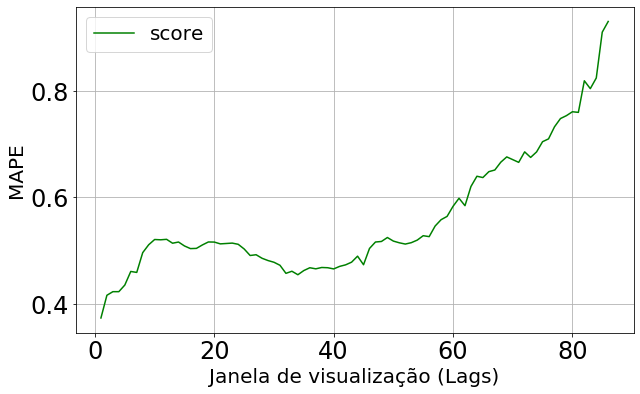

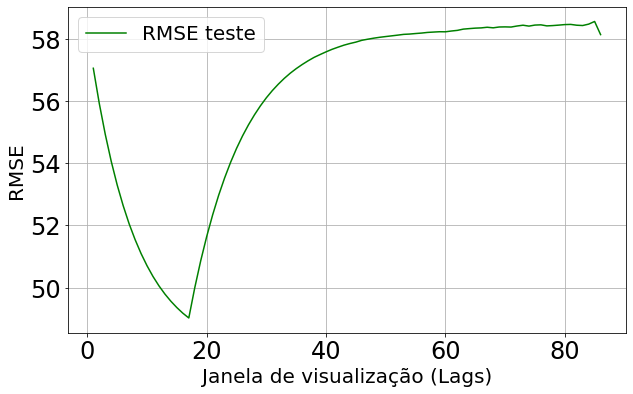

In [62]:
#lags = 17 # Equivalente à 10% dos dados de treino.
#Prepara os dados de treinamento

xlags = []

mape_treino = []
mape_teste  = []
    
rmse_treino = []
rmse_teste  = []

score = []
inter = []

for lags in range(1,87):
    
    train_X, train_y = prepara_dados(train, lags)
    
    #Prepara os dados de teste
    entradas = trainingd[len(trainingd) - len(test) - lags:].values
    entradas = entradas.reshape(-1, 1)
    entradas = sc.fit_transform(entradas)

    test_X = []
    for i in range(lags, lags+len(test)):
        test_X.append(entradas[i-lags:i, 0])
    test_X = np.array(test_X)
    
    #Cria o modelo
    model = LinearRegression()

    #Treina o modelo
    model.fit(train_X,train_y)
    score.append(model.score(train_X,train_y))
    inter.append(model.intercept_)

    #Dados de teste
    previsoes = model.predict(test_X)
    previsoes = previsoes.reshape(-1, 1)
    previsoes = sc.inverse_transform(previsoes)
    

    #Dados de treino
    previsoes_treino = model.predict(train_X)
    previsoes_treino = previsoes_treino.reshape(-1, 1)
    previsoes_treino = sc.inverse_transform(previsoes_treino)
    
    #Converte os valores de pH normalizados para o valor real de pH.
    test = sc.inverse_transform(test)
    treino = sc.inverse_transform(train[lags: len(previsoes_treino) + lags, :])
    
    xlags.append(lags)
    
    mape_treino.append(mape(previsoes_treino,treino)[0])
    mape_teste.append(mape(previsoes,test)[0])
    
    rmse_treino.append(rmse(previsoes_treino,treino))
    rmse_teste.append(rmse(previsoes,test))

#print(xlags)
#print(mape_treino)
#print(mape_teste)
#print(len(entradas))
#print(inter)
    
#Plotagem do gráfico MAPE
#plt.plot(xlags,mape_treino, color = 'green', label = 'MAPE treino')
plt.plot(xlags,score, color = 'green', label = 'score')
#plt.title('Desempenho ')
plt.xlabel('Janela de visualização (Lags)')
plt.ylabel('MAPE')
plt.legend()
plt.grid()
plt.show()
    
#Plotagem do gráfico RMSE
#plt.plot(xlags,rmse_treino, color = 'green', label = 'MAPE treino')
plt.plot(xlags,rmse_teste, color = 'green', label = 'RMSE teste')
#plt.title('Desempenho ')
plt.xlabel('Janela de visualização (Lags)')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
    


(248, 1)

174